# Finding Clusters of Apple iOS Mobile Applications

__Objective:__ Finding yet-unpredicted categories within a large set of mobile applications.

__Data:__ ([Source](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps/home))
- Contains 7000+ Apple iOS mobile application details
- Extracted from the iTunes Search API at the Apple Inc website
- 7197 rows; 16 columns

__Data Dictionary:__

- __id__: app ID
- __track_name__: app name
- __size_bytes__: app size in bytes
- __currency__: currency type
- __price__: price
- __rating_count_tot__: # user ratings (for all versions)
- __rating_count_ver__: # user ratings (for current version)
- __user_rating__: avg rating (for all versions)
- __user_rating_ver__: avg rating (for current version)
- __ver__: latest version
- __cont_rating__: content rating
- __prime_genre__: app’s primary genre
- __sup_devices.num__: # supporting devices
- __ipadSc_urls.num__: # screenshots shown for display
- __lang.num__: # supported languages
- __vpp_lic__: Vpp Device Based Licensing Enabled

# Data Exploratory Analysis (EDA) & Cleaning

In [1]:
import pandas as pd
import numpy as np
from langdetect import detect
import unicodedata as ud
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

raw_data = pd.read_csv('./applestore.csv', index_col=0)
raw_data.drop(columns=['id', 'currency'], inplace=True)
print(raw_data.shape)
print(list(raw_data.columns))
raw_data.head()

(7197, 14)
['track_name', 'size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ver', 'cont_rating', 'prime_genre', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic']


,track_name,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
1,PAC-MAN Premium,100788224,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
2,Evernote - stay organized,158578688,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
3,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
4,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
5,Bible,92774400,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [2]:
latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
        for uchr in unistr
           if uchr.isalpha())

def get_lang(x):
    if len(x.strip()) == 0:
        return None
    elif only_roman_chars(x):
        return 1
    else:
        try:
            lang = detect(x)
            return 1 if lang == 'en' else 2
        except:
            return None

def get_rating(x):
    if x == '4+':
        return 1
    elif x == '9+':
        return 2
    elif x == '12+':
        return 3
    elif x == '17+':
        return 4

hobby_genres = ['Sports', 'Photo & Video', 'Book', 'Games', 'Music']
lifestyle_genres = ['News', 'Lifestyle', 'Health & Fitness', 'Food & Drink', 'Shopping', 'Travel', 'Entertainment', 'Social Networking']
utility_genres = ['Productivity', 'Weather', 'Finance', 'Utilities', 'Navigation', 'Medical', 'Reference']
other_genres = ['Education', 'Business', 'Catalogs']

def get_prime_genre(genre):
    if genre in hobby_genres:
        return 1
    elif genre in lifestyle_genres:
        return 2
    elif genre in utility_genres:
        return 3
    elif genre in other_genres:
        return 0

df = raw_data.copy()

df['lang'] = df['track_name'].apply(get_lang)
df['prime_genre'] = df['prime_genre'].apply(get_prime_genre)
df['cont_rating'] = df['cont_rating'].apply(get_rating)

df = df[df['prime_genre'] != 0]
df['prime_genre'].value_counts()

1    4575
2    1367
3     735
Name: prime_genre, dtype: int64

In [3]:
for col in df.columns:
    uniq_vals = len(df[col].unique())
    print(col, '-', uniq_vals, 'uniq vals')

track_name - 6675 uniq vals
size_bytes - 6603 uniq vals
price - 33 uniq vals
rating_count_tot - 3072 uniq vals
rating_count_ver - 1119 uniq vals
user_rating - 10 uniq vals
user_rating_ver - 10 uniq vals
ver - 1540 uniq vals
cont_rating - 4 uniq vals
prime_genre - 3 uniq vals
sup_devices.num - 20 uniq vals
ipadSc_urls.num - 6 uniq vals
lang.num - 57 uniq vals
vpp_lic - 2 uniq vals
lang - 2 uniq vals


size_bytes - Avg: 201779103.11 ; Median: 96720896.0
price - Avg: 1.54 ; Median: 0.0
rating_count_tot - Avg: 13701.61 ; Median: 325.0
user_rating - Avg: 3.54 ; Median: 4.0


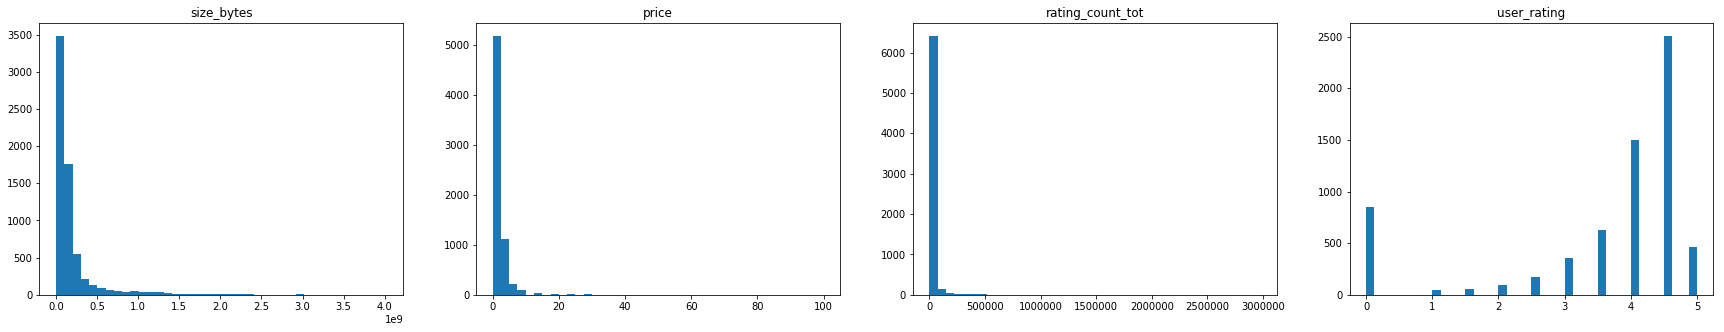

In [4]:
continuous_cols = ['size_bytes', 'price', 'rating_count_tot', 'user_rating']

plt.figure(figsize=(30,5))

for idx, col in enumerate(continuous_cols):
    plt.subplot(1, 4, idx + 1)
    plt.hist(df[col], bins=40)
    plt.title(col)
    print(col, '- Avg:', round(df[col].mean(), 2), '; Median:', round(df[col].median(), 2))

plt.show()

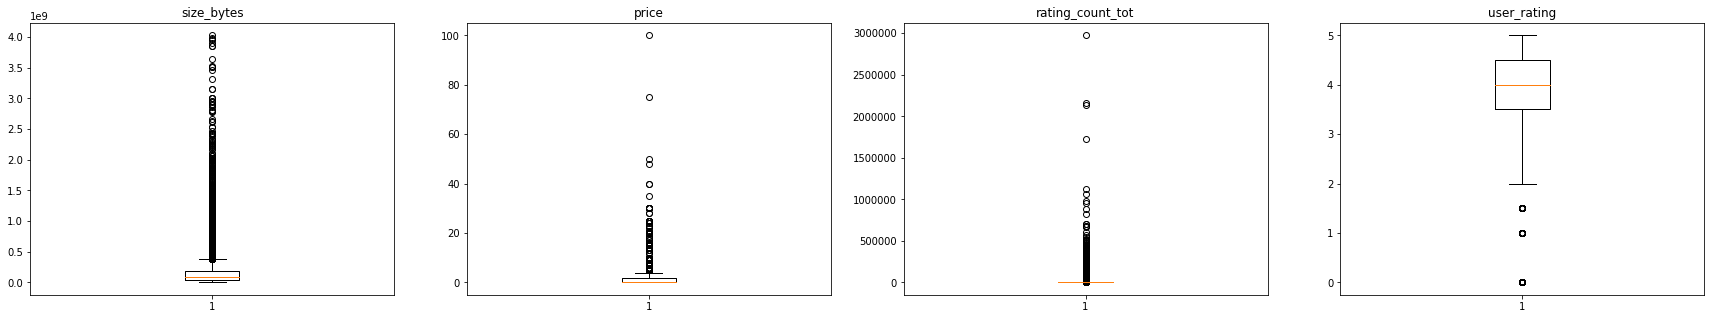

In [5]:
plt.figure(figsize=(30,5))

for idx, col in enumerate(continuous_cols):
    plt.subplot(1, 4, idx + 1)
    plt.boxplot(df[col])
    plt.title(col)

plt.show()

In [6]:
df['major_v'] = df['ver'].str.extract('(\d+)', expand=False).str.split('.').apply(lambda x:x[0])
df['major_v'] = pd.to_numeric(df['major_v'], errors='coerce').fillna(0).astype(np.int64)

df['up_to_v_1'] = df['major_v'].apply(lambda x: 1 if x <= 1 else 0)

# df['improving_rating'] = df['user_rating_ver'] > df['user_rating']

df.drop(columns=['ver', 'track_name', 'major_v', 'rating_count_ver', 'user_rating_ver', 'vpp_lic', 'ipadSc_urls.num', 'sup_devices.num'], inplace=True)
df.head()

,size_bytes,price,rating_count_tot,user_rating,cont_rating,prime_genre,lang.num,lang,up_to_v_1
1,100788224,3.99,21292,4.0,1,1,10,1,0
2,158578688,0.00,161065,4.0,1,3,23,1,0
3,100524032,0.00,188583,3.5,1,3,3,1,0
4,128512000,0.00,262241,4.0,3,2,9,1,0
5,92774400,0.00,985920,4.5,1,3,45,1,0


In [7]:
cols_to_norm = continuous_cols

# Normalize data before clustering
df = df.dropna(subset=cols_to_norm)

cluster_df = df.copy()
cluster_df[cols_to_norm] = normalize(cluster_df[cols_to_norm])
    
cluster_df = pd.concat([cluster_df[cols_to_norm], cluster_df[cluster_df.columns.difference(cols_to_norm)]], axis=1)

print(cluster_df.shape[0], 'rows;', cluster_df.shape[1], 'columns')
print(list(cluster_df.columns))

cluster_df.head()

6677 rows; 9 columns
['size_bytes', 'price', 'rating_count_tot', 'user_rating', 'cont_rating', 'lang', 'lang.num', 'prime_genre', 'up_to_v_1']


,size_bytes,price,rating_count_tot,user_rating,cont_rating,lang,lang.num,prime_genre,up_to_v_1
1,1.000000,3.958796e-08,0.000211,3.968718e-08,1,1,10,1,0
2,0.999999,0.000000e+00,0.001016,2.522406e-08,1,1,23,3,0
3,0.999998,0.000000e+00,0.001876,3.481748e-08,1,1,3,3,0
4,0.999998,0.000000e+00,0.002041,3.112543e-08,3,1,9,2,0
5,0.999944,0.000000e+00,0.010626,4.850202e-08,1,1,45,3,0


## Creating Unsupervised Clustering Models

In [8]:
bandwidth = estimate_bandwidth(cluster_df, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_pred = ms.fit_predict(cluster_df)

np.unique(ms_pred)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [9]:
kmeans_4_pred = KMeans(n_clusters=4, random_state=10).fit_predict(cluster_df)
np.unique(kmeans_4_pred)

array([0, 1, 2, 3], dtype=int32)

In [10]:
minibatchkmeans = MiniBatchKMeans(init='random', n_clusters=4, batch_size=200)
minibatchkmeans.fit(cluster_df)

# Add the new predicted cluster memberships to the data frame.
mini_pred = minibatchkmeans.predict(cluster_df)
print(np.unique(mini_pred))

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(mini_pred, kmeans_4_pred))

[0 1 2 3]
Comparing k-means and mini batch k-means solutions:
col_0     0    1    2   3
row_0                    
0         0  238    0  36
1      4537    0    0   0
2       325    0  801   0
3         0   77  663   0


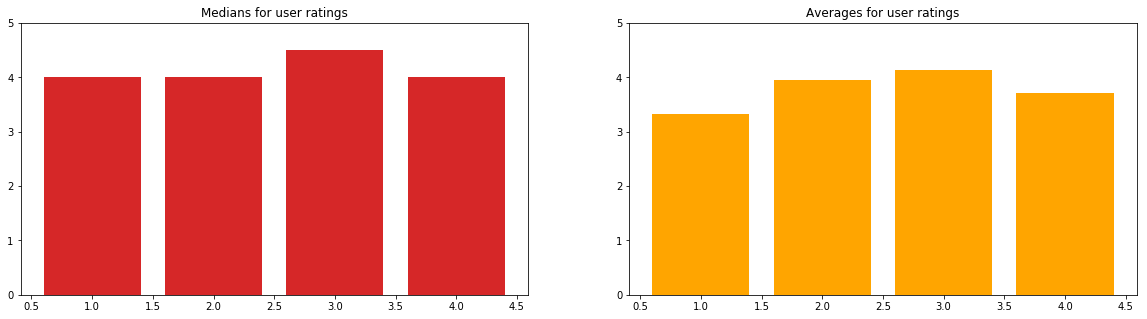

In [11]:
df['kmeans_4_pred'] = kmeans_4_pred

cluster_1 = df[df['kmeans_4_pred'] == 0].loc[:, df.columns != 'kmeans_4_pred']
cluster_2 = df[df['kmeans_4_pred'] == 1].loc[:, df.columns != 'kmeans_4_pred']
cluster_3 = df[df['kmeans_4_pred'] == 2].loc[:, df.columns != 'kmeans_4_pred']
cluster_4 = df[df['kmeans_4_pred'] == 3].loc[:, df.columns != 'kmeans_4_pred']
all_clusters = [cluster_1, cluster_2, cluster_3, cluster_4]

# MEDIANS
clusters_medians_df = pd.DataFrame()
for idx, cluster in enumerate(all_clusters):
    for col in cluster.columns:
        clusters_medians_df.at[idx, col] = cluster[col].median()

cols_to_compare = ['user_rating']

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)

for rowIdx in range(len(all_clusters)):
    bars = clusters_medians_df[cols_to_compare].values.flatten()
    plt.bar(range(1, len(all_clusters) + 1), height=bars)
    plt.ylim((0, 5))
    plt.title('Medians for user ratings')

# MEANS
clusters_means_df = pd.DataFrame()
for idx, cluster in enumerate(all_clusters):
    for col in cluster.columns:
        clusters_means_df.at[idx, col] = cluster[col].mean()

plt.subplot(1, 2, 2)

for rowIdx in range(len(all_clusters)):
    bars = clusters_means_df[cols_to_compare].values.flatten()
    plt.bar(range(1, len(all_clusters) + 1), height=bars, color='orange')
    plt.ylim((0, 5))
    plt.title('Averages for user ratings')
    
plt.show()

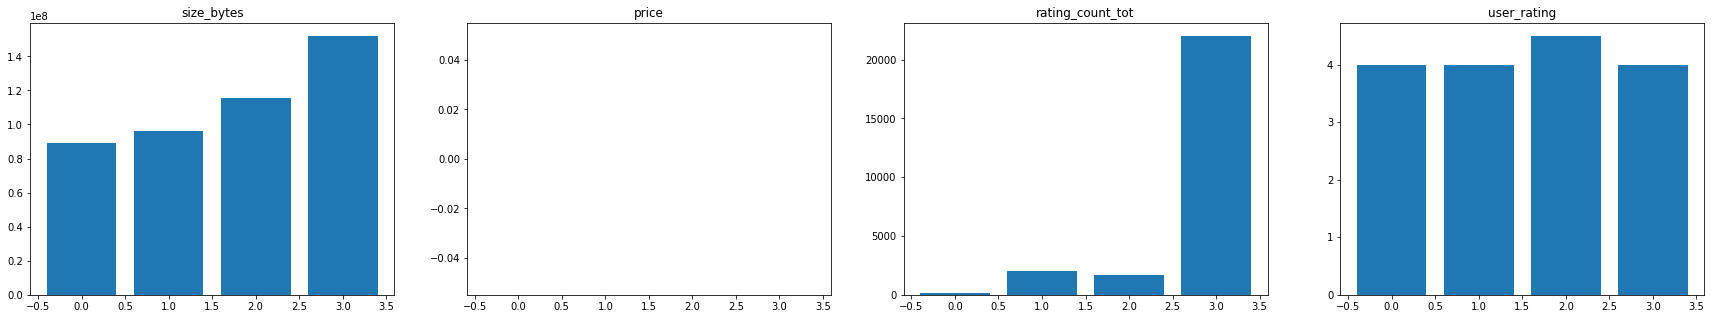

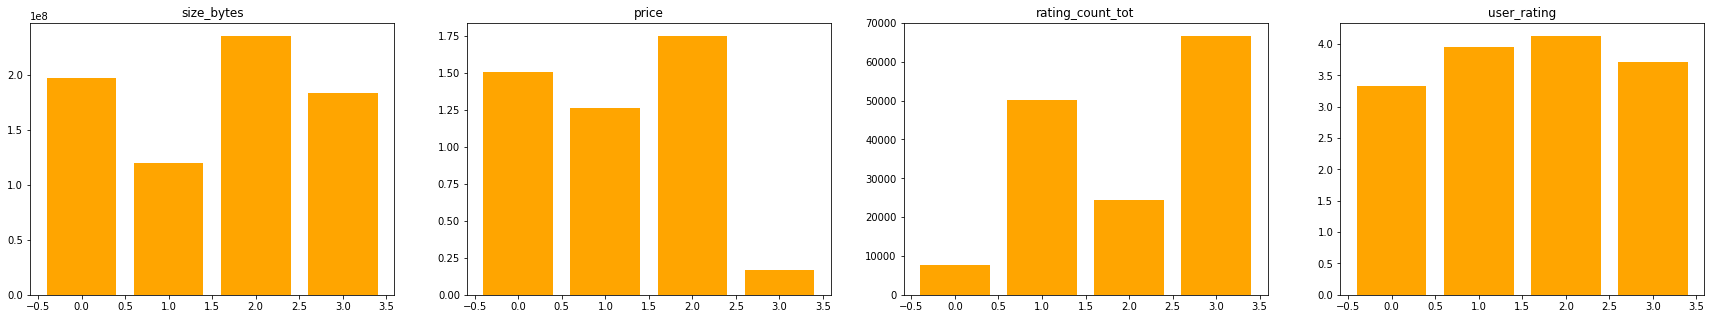

In [12]:
# MEDIANS
plt.figure(figsize=(30,5))

cols_1 = ['size_bytes', 'price', 'rating_count_tot', 'user_rating']

for idx, col in enumerate(cols_1):
    plt.subplot(1, 4, idx + 1)
    plt.bar(clusters_medians_df.index, height=clusters_medians_df[col])
    plt.title(col)
plt.show()

# MEANS
plt.figure(figsize=(30,5))

for idx, col in enumerate(cols_1):
    plt.subplot(1, 4, idx + 1)
    plt.bar(clusters_means_df.index, height=clusters_means_df[col], color='orange')
    plt.title(col)
plt.show()

In [13]:
categ_cols = ['prime_genre', 'cont_rating', 'lang']

for idx, col in enumerate(categ_cols):
    print('***', col, '***')
    for cluster_idx, cluster in enumerate(all_clusters):
        print('   Cluster', cluster_idx + 1)
        print(cluster[col].value_counts())
    print('\n')

*** prime_genre ***
   Cluster 1
1    3316
2    1040
3     506
Name: prime_genre, dtype: int64
   Cluster 2
1    157
2     94
3     64
Name: prime_genre, dtype: int64
   Cluster 3
1    1086
2     227
3     151
Name: prime_genre, dtype: int64
   Cluster 4
1    16
3    14
2     6
Name: prime_genre, dtype: int64


*** cont_rating ***
   Cluster 1
1    2748
3     866
2     759
4     489
Name: cont_rating, dtype: int64
   Cluster 2
1    233
3     38
4     22
2     22
Name: cont_rating, dtype: int64
   Cluster 3
1    940
3    236
2    198
4     90
Name: cont_rating, dtype: int64
   Cluster 4
1    20
4    10
3     5
2     1
Name: cont_rating, dtype: int64


*** lang ***
   Cluster 1
1    3903
2     959
Name: lang, dtype: int64
   Cluster 2
1    312
2      3
Name: lang, dtype: int64
   Cluster 3
1    1443
2      21
Name: lang, dtype: int64
   Cluster 4
1    34
2     2
Name: lang, dtype: int64




In [16]:
clusters_medians_df

,size_bytes,price,rating_count_tot,user_rating,cont_rating,prime_genre,lang.num,lang,up_to_v_1
0,89191424.0,0.0,154.0,4.0,1.0,1.0,1.0,1.0,1.0
1,95927296.0,0.0,2027.0,4.0,1.0,2.0,28.0,1.0,0.0
2,115485184.0,0.0,1672.5,4.5,1.0,1.0,11.0,1.0,1.0
3,151970816.0,0.0,22002.5,4.0,1.0,2.0,46.0,1.0,0.0


In [17]:
clusters_means_df

,size_bytes,price,rating_count_tot,user_rating,cont_rating,prime_genre,lang.num,lang,up_to_v_1
0,1.971146e+08,1.507470,7725.030029,3.331756,1.814068,1.422049,1.591937,1.197244,0.619087
1,1.198778e+08,1.266698,50143.825397,3.944444,1.520635,1.704762,27.285714,1.009524,0.374603
2,2.353348e+08,1.751960,24406.464481,4.128757,1.642077,1.361339,11.639344,1.014344,0.511612
3,1.837912e+08,0.166111,66671.416667,3.708333,2.138889,1.944444,51.194444,1.055556,0.361111


In [15]:
for col in clusters_medians_df:
    print(col)
    for group in range(len(all_clusters)):
        if col not in categ_cols:
            mean = round(clusters_means_df.iloc[group][col], 2)
            med = round(clusters_medians_df.iloc[group][col], 2)
            print('   Group', group + 1, '– Avg:', mean, 'Median:', med)

size_bytes
   Group 1 – Avg: 197114552.63 Median: 89191424.0
   Group 2 – Avg: 119877824.0 Median: 95927296.0
   Group 3 – Avg: 235334779.51 Median: 115485184.0
   Group 4 – Avg: 183791246.22 Median: 151970816.0
price
   Group 1 – Avg: 1.51 Median: 0.0
   Group 2 – Avg: 1.27 Median: 0.0
   Group 3 – Avg: 1.75 Median: 0.0
   Group 4 – Avg: 0.17 Median: 0.0
rating_count_tot
   Group 1 – Avg: 7725.03 Median: 154.0
   Group 2 – Avg: 50143.83 Median: 2027.0
   Group 3 – Avg: 24406.46 Median: 1672.5
   Group 4 – Avg: 66671.42 Median: 22002.5
user_rating
   Group 1 – Avg: 3.33 Median: 4.0
   Group 2 – Avg: 3.94 Median: 4.0
   Group 3 – Avg: 4.13 Median: 4.5
   Group 4 – Avg: 3.71 Median: 4.0
cont_rating
prime_genre
lang.num
   Group 1 – Avg: 1.59 Median: 1.0
   Group 2 – Avg: 27.29 Median: 28.0
   Group 3 – Avg: 11.64 Median: 11.0
   Group 4 – Avg: 51.19 Median: 46.0
lang
up_to_v_1
   Group 1 – Avg: 0.62 Median: 1.0
   Group 2 – Avg: 0.37 Median: 0.0
   Group 3 – Avg: 0.51 Median: 1.0
   Grou

## Conclusion

Looking at the 4 clusters that appear in my data, I can start differentiating them from each other based on the features I selected. 

- Group 1 
    - Fewest Ratings
    - Lowest Ratings
    - Least Language Support
    - Mid Price Range
    - Mid Size
    - Up to 1 Major Version
- Group 2 
    - Mid-High Range # of Ratings
    - Mid-High Range Ratings
    - Mid-High Language Support
    - Mid Price Range
    - Largest
    - More than 1 Major Version
- Group 3 
    - Mid-Low Range # of Ratings
    - Highest Ratings
    - Mid-Low Language Support
    - Most Expensive
    - Smallest
    - Up to 1 Major Version
- Group 4 
    - Most Ratings
    - Mid-Range Ratings
    - Most Language Support
    - Cheapest
    - Mid Size
    - More than 1 Major Version
    
In more human-readable terms, I'd roughly categorize the 4 groups as such:

- The majority of apps in all groups fall into the Hobby genre , followed by Lifestyle.
- __Group 1 – "Obscure Bad Apps"__
    - Least Frequently & Most Lowly Rated; Underdeveloped (languages, versions)
- __Group 2 – "Solid Veterans"__
    - Decent Mid-High #s All Around (# ratings, ratings, languages, price); Largest & More Developed
- __Group 3 – "Under-the-Radar Cult Favorites"__
    - Fewer, But Highest, Ratings; Smallest But Most Expensive; Limited Development (languages, versions)
- __Group 4 – "Ubiquitous Global Mainstays"__
    - Most Frequently Rated (Mid Range); Cheapest; Most Global-Friendly (languages) & Developed (versions)
    - Has Significantly More Utility Apps